### 能量分布FFT分析

数据加载成功: 17420 行

📊 数据分析报告 (Window=512)
1. 高频能量占比: 1.26% (主要能量集中在低频趋势)
2. 信号锯齿度:   0.3107 (中等，非极度平滑也非极度噪杂)
------------------------------
💡 选型建议:
>> 推荐: Sym3 (Symlets 3)
   原因: 数据处于中间态 (Ratio=1.3%, Jag=0.31)。
         Sym3 既能捕捉趋势，又比 Db4 更少产生边界振铃。


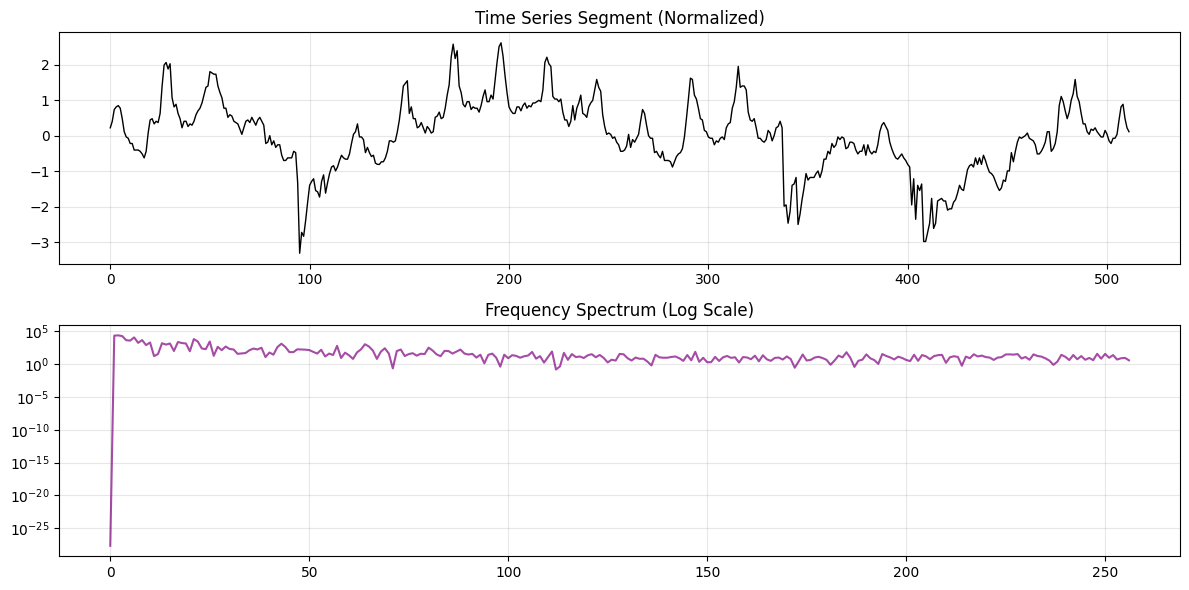

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import rfft, rfftfreq

def analyze_etth1_data(file_path, seq_len=512):
    # 1. 加载数据
    df = pd.read_csv(file_path)
    print(f"数据加载成功: {len(df)} 行")
    
    # 提取 OT 列 (Oil Temperature)
    data = df['OT'].values
    
    # 取最后 seq_len 个点作为观测窗口 (模拟你的 Patching 输入)
    if len(data) > seq_len:
        signal = data[-seq_len:]
    else:
        signal = data
        
    # 归一化 (模拟 StandardNorm)
    signal = (signal - signal.mean()) / signal.std()
    
    # 2. FFT 频谱分析
    N = len(signal)
    yf = rfft(signal)
    xf = rfftfreq(N, 1/N)
    
    power = np.abs(yf)**2
    total_power = np.sum(power)
    
    # 简单切分高低频 (后50%为高频)
    split_idx = len(power) // 2
    high_freq_power = np.sum(power[split_idx:])
    hf_ratio = high_freq_power / total_power
    
    # 3. 锯齿度/平滑度分析
    # 计算一阶差分 (变化率)
    diffs = np.diff(signal)
    # 锯齿度 = 差分的波动 / 原始信号的波动
    # 值越小越平滑，值越大越接近随机噪声
    jaggedness = np.std(diffs) / np.std(signal)
    
    print("\n" + "="*30)
    print(f"📊 数据分析报告 (Window={seq_len})")
    print("="*30)
    print(f"1. 高频能量占比: {hf_ratio:.2%} (主要能量集中在低频趋势)")
    print(f"2. 信号锯齿度:   {jaggedness:.4f} (中等，非极度平滑也非极度噪杂)")
    print("-" * 30)
    print("💡 选型建议:")
    
    if hf_ratio > 0.2 or jaggedness > 0.8:
        print(">> 推荐: Haar (db1)")
        print("   原因: 数据包含大量突变和噪声，Haar 反应最快且无伪影。")
    elif hf_ratio < 0.05 and jaggedness < 0.2:
        print(">> 推荐: Db4 / Sym5")
        print("   原因: 数据非常平滑，长滤波器能完美拟合趋势。")
    else:
        print(">> 推荐: Sym3 (Symlets 3)")
        print(f"   原因: 数据处于中间态 (Ratio={hf_ratio:.1%}, Jag={jaggedness:.2f})。")
        print("         Sym3 既能捕捉趋势，又比 Db4 更少产生边界振铃。")
        
    # 4. 绘图
    plt.figure(figsize=(12, 6))
    
    plt.subplot(2, 1, 1)
    plt.plot(signal, color='black', linewidth=1)
    plt.title("Time Series Segment (Normalized)")
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 1, 2)
    plt.plot(xf, power, color='purple', alpha=0.7)
    plt.title("Frequency Spectrum (Log Scale)")
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# 运行分析
if __name__ == "__main__":
    analyze_etth1_data('/home/dmx_MT/LZF/project/CAST/dataset/ETT-small/ETTh1.csv')

成功读取 /home/dmx_MT/LZF/project/CAST/dataset/ETT-small/ETTh1.csv, 数据形状: (17420, 8)


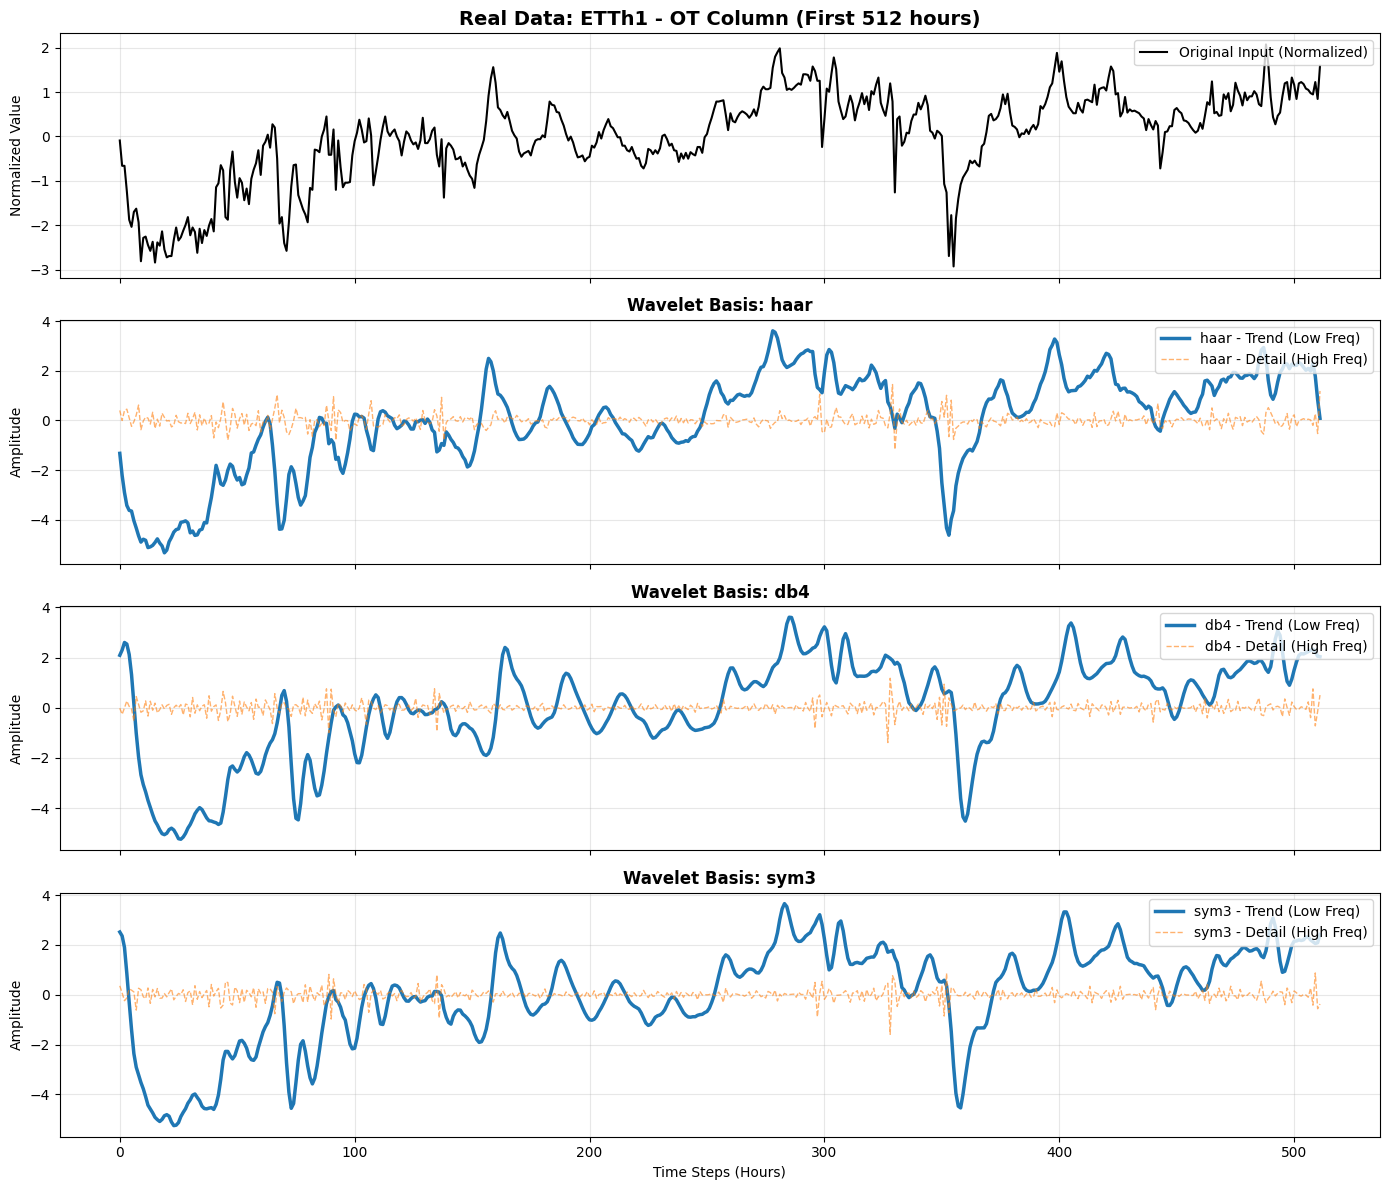

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pywt

def run_analysis():
    # 1. 读取真实的 ETTh1 数据
    # -------------------------------------------------------
    filename = '/home/dmx_MT/LZF/project/CAST/dataset/ETT-small/ETTh1.csv'
    try:
        df = pd.read_csv(filename)
        print(f"成功读取 {filename}, 数据形状: {df.shape}")
    except FileNotFoundError:
        print(f"❌ 找不到文件 {filename}，请确保文件在当前目录下")
        return

    # 2. 数据预处理
    # -------------------------------------------------------
    # 我们选取 'OT' (Oil Temperature) 列，因为它包含明显的周期性和趋势，
    # 非常适合观察 'sym5' 和 'haar' 的区别。
    target_col = 'OT' 
    
    # SWT (平稳小波变换) 要求数据长度最好是 2^n。
    # 我们截取前 512 个时间步（约 21 天的数据，如果按小时采样），
    # 这样能清晰看到日周期的波形。
    data_len = 512 
    signal = df[target_col].iloc[:data_len].values

    # 简单归一化 (Z-Score)，这符合 Time-LLM 等模型的预处理习惯
    signal_mean = np.mean(signal)
    signal_std = np.std(signal)
    signal_norm = (signal - signal_mean) / signal_std

    # 3. 定义要对比的小波基
    # -------------------------------------------------------
    wavelets = ['haar', 'db4', 'sym3']
    level = 2 # 分解深度

    # 4. 绘图设置
    # -------------------------------------------------------
    fig, axes = plt.subplots(len(wavelets) + 1, 1, figsize=(14, 12), sharex=True)

    # --- 绘制原始信号 ---
    axes[0].plot(signal_norm, color='black', linewidth=1.5, label='Original Input (Normalized)')
    axes[0].set_title(f"Real Data: ETTh1 - {target_col} Column (First {data_len} hours)", fontsize=14, fontweight='bold')
    axes[0].legend(loc='upper right')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylabel('Normalized Value')

    # --- 循环对比不同小波基 ---
    for i, w_name in enumerate(wavelets):
        ax = axes[i+1]
        
        # 执行 SWT (Stationary Wavelet Transform)
        # 结果格式: [(cA_level, cD_level), ..., (cA_1, cD_1)]
        coeffs = pywt.swt(signal_norm, w_name, level=level)
        
        # 提取分解后的成分：
        # cA2: 近似分量 (Approximation) -> 代表长期的趋势 (Trend)
        # cD1: 细节分量 (Detail)       -> 代表高频噪声或突变 (Noise)
        cA2 = coeffs[0][0]
        cD1 = coeffs[-1][1]
        
        # 绘制趋势 (Trend) - 这是一个低通滤波的结果
        ax.plot(cA2, linewidth=2.5, label=f'{w_name} - Trend (Low Freq)', color='#1f77b4')
        
        # 绘制噪声/细节 (Noise) - 这是一个高通滤波的结果
        # 为了不遮挡趋势，我们把细节画淡一点，或者画在趋势上方
        ax.plot(cD1, color='#ff7f0e', alpha=0.6, linewidth=1, linestyle='--', label=f'{w_name} - Detail (High Freq)')
        
        ax.set_title(f"Wavelet Basis: {w_name}", fontsize=12, fontweight='bold')
        ax.legend(loc='upper right')
        ax.grid(True, alpha=0.3)
        ax.set_ylabel('Amplitude')

    plt.xlabel('Time Steps (Hours)')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_analysis()

### Haar, Db4, Sym5 三种小波基针对数据的香农熵

In [3]:
import pandas as pd
import numpy as np
import pywt

def calculate_entropy(coeffs):
    """
    计算小波系数的香农熵 (Shannon Entropy)
    熵越小 -> 能量越集中 -> 特征提取越好
    """
    # 展平所有系数 (近似分量 + 细节分量)
    # coeffs 格式: [cA, cD] or [(cA_n, cD_n), ..., (cA_1, cD_1)]
    if isinstance(coeffs, list):
        # 针对 SWT 输出的处理
        all_coeffs = np.concatenate([c for level in coeffs for c in level])
    else:
        # 针对 DWT 输出的处理
        all_coeffs = np.concatenate(coeffs)
    
    # 能量归一化
    energy = all_coeffs ** 2
    total_energy = np.sum(energy)
    prob = energy / total_energy
    
    # 计算熵 (避免 log(0))
    entropy = -np.sum(prob * np.log(prob + 1e-10))
    return entropy

# 1. 读取数据
df = pd.read_csv('/home/dmx_MT/LZF/project/CAST/dataset/ETT-small/ETTh1.csv')
signal = df['OT'].values[:1024] # 取前1024个点测试

# 2. 归一化 (关键步骤)
signal = (signal - np.mean(signal)) / np.std(signal)

# 3. 对比不同小波基
wavelets = ['haar', 'db4', 'sym5']
results = {}

print(f"{'Wavelet':<10} | {'Entropy (Lower is better)':<25}")
print("-" * 40)

for w in wavelets:
    # 使用 SWT 分解 (level=2)
    coeffs = pywt.swt(signal, w, level=2)
    
    # 计算熵
    e = calculate_entropy(coeffs)
    results[w] = e
    print(f"{w:<10} | {e:.4f}")

best_wavelet = min(results, key=results.get)
print("-" * 40)
print(f"🏆 推荐使用的最佳小波基: {best_wavelet}")

Wavelet    | Entropy (Lower is better)
----------------------------------------
haar       | 6.8239
db4        | 6.7966
sym5       | 6.7947
----------------------------------------
🏆 推荐使用的最佳小波基: sym5


### 可视化 Phase Shift (相位偏移)

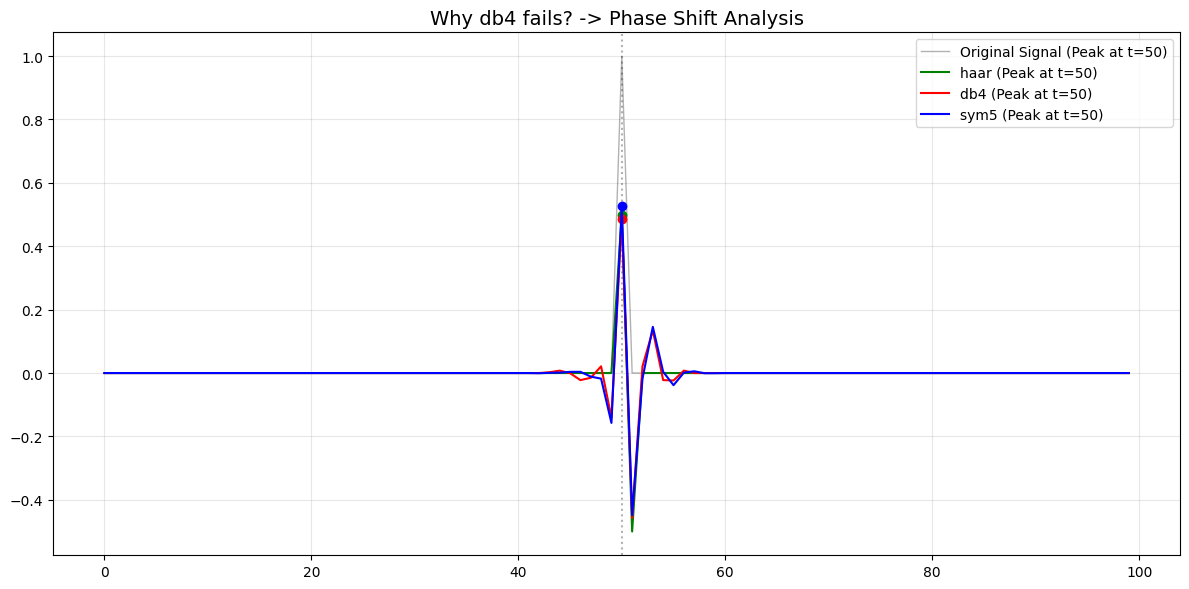

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

def visualize_phase_shift():
    # 1. 创建一个单纯的脉冲信号
    # 在 t=50 的地方有一个尖峰，其他都是0
    length = 100
    signal = np.zeros(length)
    signal[50] = 1.0  # 原始峰值位置

    wavelets = ['haar', 'db4', 'sym5']
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # 绘制原始位置
    ax.plot(signal, 'k-', linewidth=1, alpha=0.3, label='Original Signal (Peak at t=50)')
    ax.axvline(x=50, color='k', linestyle=':', alpha=0.3)

    colors = {'haar': 'green', 'db4': 'red', 'sym5': 'blue'}
    
    # 2. 对比变换后的重构细节
    # 我们只看 Detail 系数（高频部分），看看它把这个峰值搬到哪去了
    for w in wavelets:
        # 使用 DWT 单层分解
        cA, cD = pywt.dwt(signal, w, mode='periodization')
        
        # 为了看清楚位置，我们需要把系数 upsample 回原始长度
        # 这里简单地用 IDWT 重构，但把 cA 置零，只看 cD (细节) 的时域表现
        rec_detail = pywt.idwt(None, cD, w, mode='periodization')
        
        # 寻找变换后的峰值位置
        peak_idx = np.argmax(np.abs(rec_detail))
        
        ax.plot(rec_detail, color=colors[w], label=f'{w} (Peak at t={peak_idx})')
        ax.plot(peak_idx, rec_detail[peak_idx], 'o', color=colors[w])

    ax.set_title("Why db4 fails? -> Phase Shift Analysis", fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

visualize_phase_shift()